## Zadanie 1

Proszę pobrać plik medicine.txt, zawierający wyniki analizy nowego leku. W dwóch pierwszych kolumnach znajduje się stężenie dwóch składników w próbce krwi, w trzeciej - informacja o tym, czy lek zadziałał. Dane nie są znormalizowane. Proszę znormalizować dane, podzielić je na zbiór uczący i testujący w proporcjach 80-20 (należy pamiętać o proporcjach klas), zaproponować wielowarstwową sieć neuronową i zbadać jej skuteczność dla różnych ilości warstw i neuronów w tych warstwach. Proszę narysować w jaki sposób sieć dokonała podziału w zbiorze dla kilku sieci (zarówno tych z dobrymi, jak i złymi wynikami) oraz jak wygląda poprawny podział zbioru. Proszę również przedstawić wyniki dla 5-8 różnych struktur sieci, wraz z oceną, która z nich najlepiej poradziła sobie z zadaniem klasyfikacji.

Architecture (5,) -> Accuracy: 0.8741
Architecture (10,) -> Accuracy: 0.8556
Architecture (10, 5) -> Accuracy: 0.8963
Architecture (50,) -> Accuracy: 0.9037
Architecture (20, 10, 5) -> Accuracy: 0.8963
Architecture (50, 30, 20, 10) -> Accuracy: 0.8963
Architecture (100,) -> Accuracy: 0.8963
Architecture (50, 25) -> Accuracy: 0.9037

Best network: (50,), with accuracy: 0.9037
Worst network: (10,), with accuracy: 0.8556


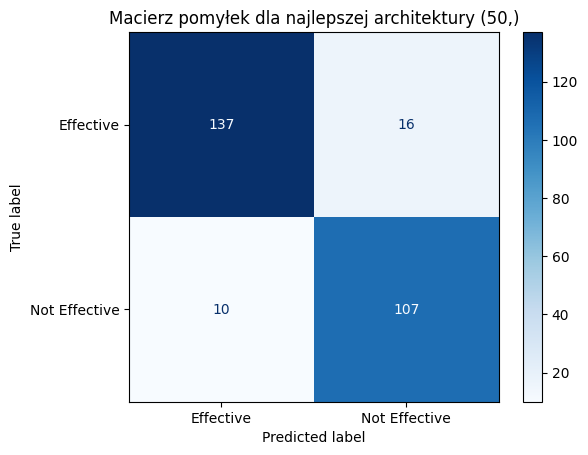

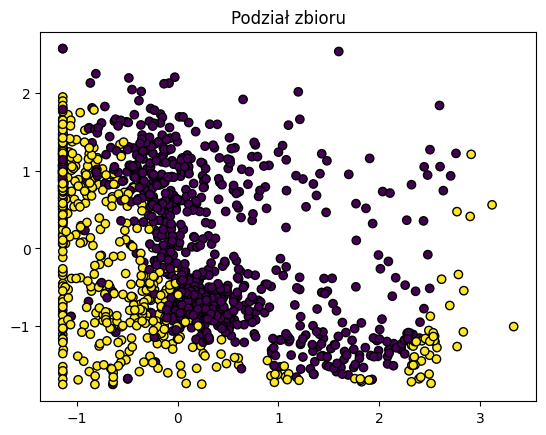

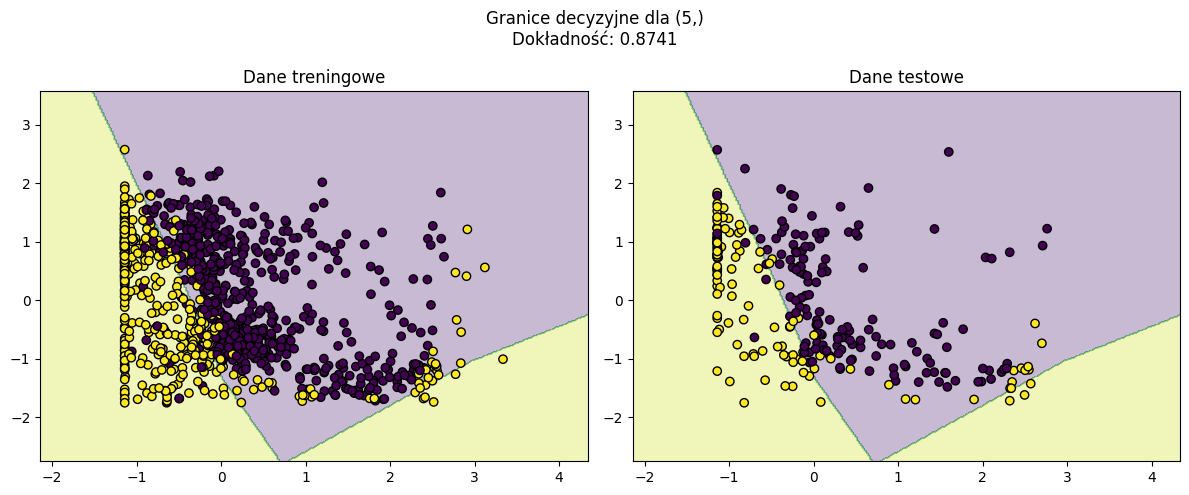

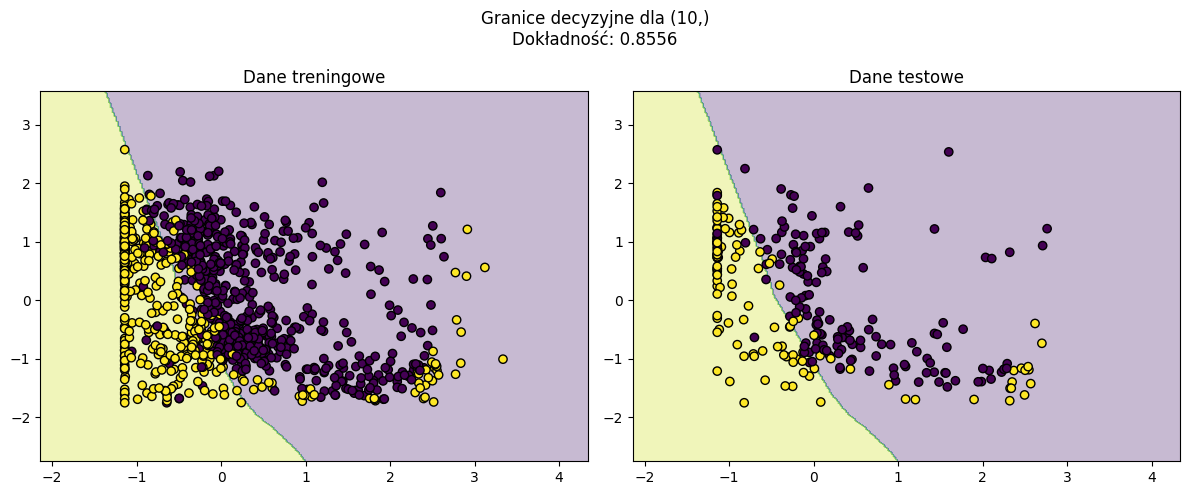

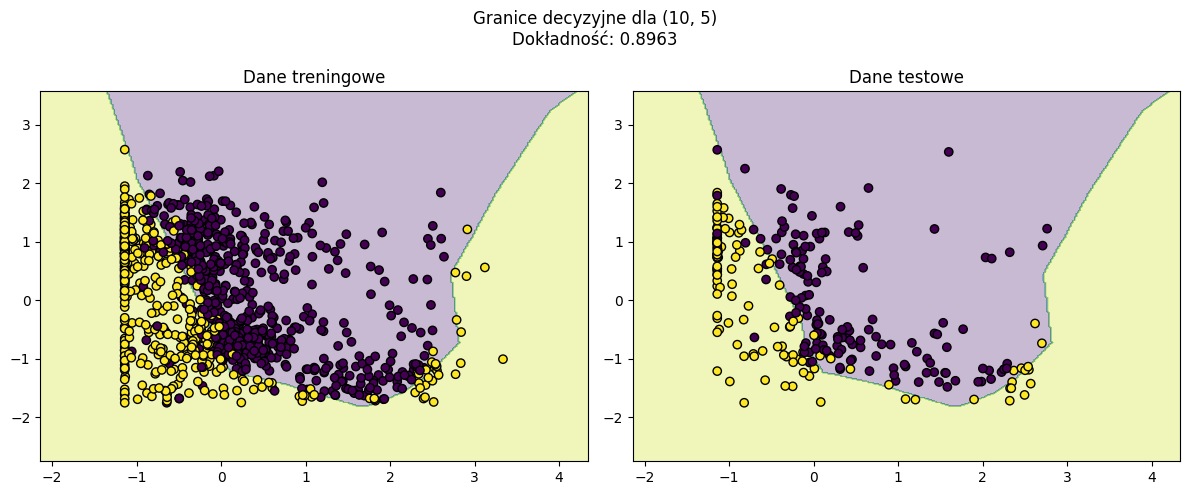

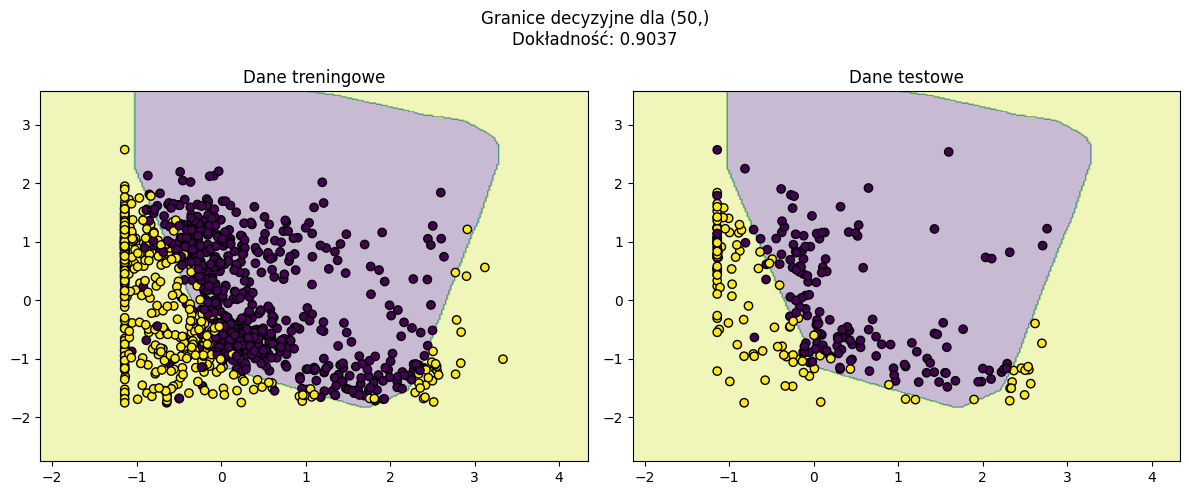

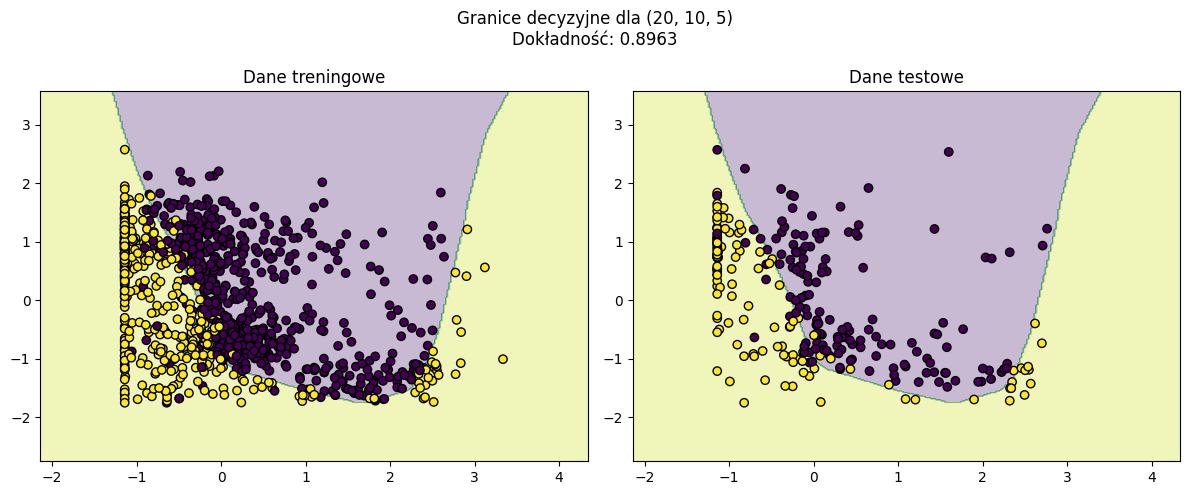

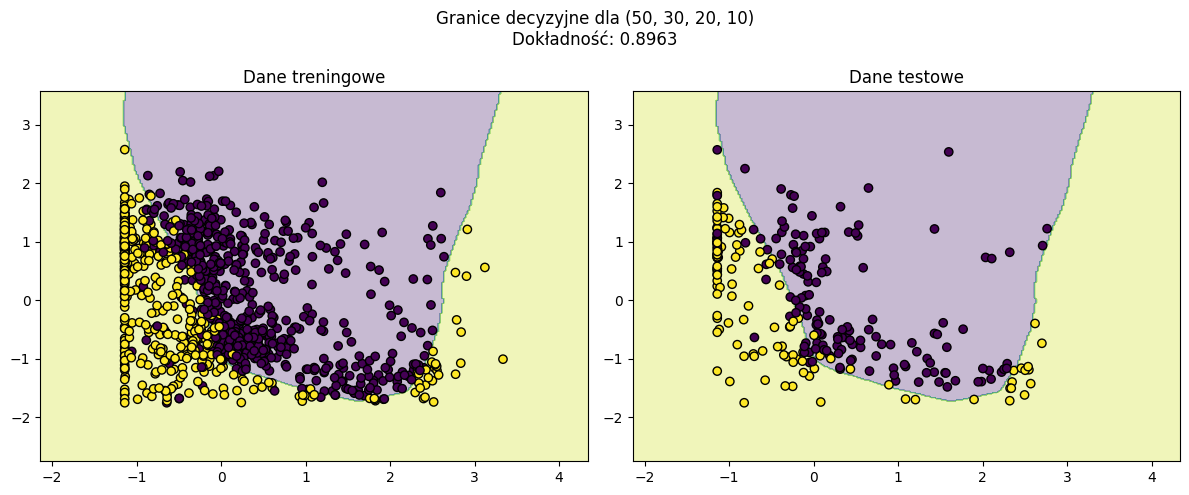

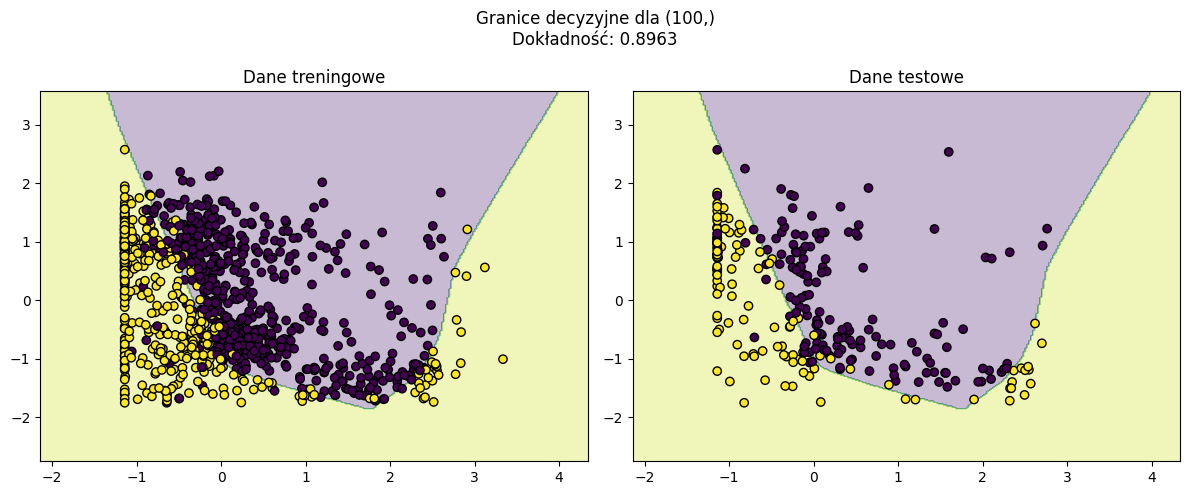

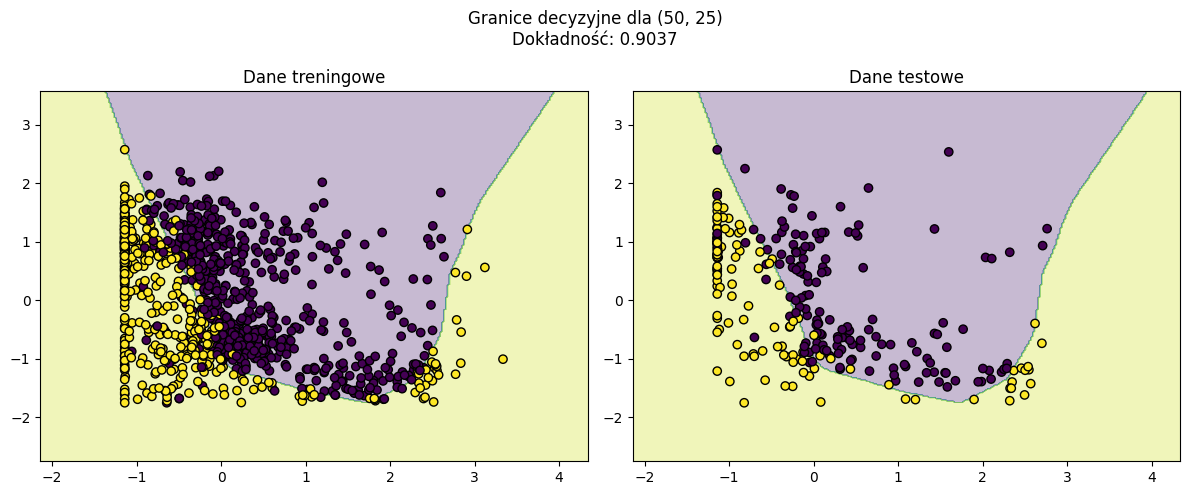

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# load data
medicine_data = pd.read_csv(os.path.join("data", "medicine.txt"))
X, y = (
    medicine_data.drop("Was medicine effective?", axis=1),
    medicine_data["Was medicine effective?"],
)


# find outliers -> 3-sigma rule
def find_and_remove_outliers(X, y):
    n_cols, n_rows = X.shape

    feature_means = X.mean()
    feature_stdevs = X.std()

    outlier_mask = (
        (X < feature_means - 3 * feature_stdevs)
        | (X > feature_means + 3 * feature_stdevs)
    ).any(axis=1)

    X_cleaned = X[~outlier_mask]
    y_cleaned = y[~outlier_mask]

    return X_cleaned, y_cleaned


def scale_data(X, y):
    scaler = StandardScaler()
    return scaler.fit_transform(X, y)


def prepare_data(X, y, train_size=0.8):
    X, y = find_and_remove_outliers(X, y)
    X = scale_data(X, y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, stratify=y
    )

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = prepare_data(X, y)

# no sense in testing networks, where no of neurons increase in futher layers
architectures = [
    (5,),
    (10,),
    (10, 5),
    (50,),
    (20, 10, 5),
    (50, 30, 20, 10),
    (100,),
    (50, 25),
]

results = {}
fitted_classifiers = {}

for arch in architectures:
    mlp = MLPClassifier(hidden_layer_sizes=arch, max_iter=2000)
    mlp.fit(X_train, y_train)

    y_pred = mlp.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    results[arch] = accuracy
    fitted_classifiers[arch] = mlp
    print(f"Architecture {arch} -> Accuracy: {accuracy:.4}")


def plot_decision_boundary(X_train, y_train, X_test, y_test, title, classifier):
    X_all = np.vstack((X_train, X_test))

    x_min, x_max = X_all[:, 0].min() - 1, X_all[:, 0].max() + 1
    y_min, y_max = X_all[:, 1].min() - 1, X_all[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    Z = classifier.predict(grid).reshape(xx.shape)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # train data
    axs[0].contourf(xx, yy, Z, alpha=0.3)
    axs[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor="k")
    axs[0].set_title("Dane treningowe")
    axs[0].set_xlim(x_min, x_max)
    axs[0].set_ylim(y_min, y_max)

    # test data
    axs[1].contourf(xx, yy, Z, alpha=0.3)
    axs[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor="k")
    axs[1].set_title("Dane testowe")
    axs[1].set_xlim(x_min, x_max)
    axs[1].set_ylim(y_min, y_max)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


def plot_set(X, y, title):
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
    plt.title(title)
    plt.show()


def plot_confusion_matrix(X, y, title, classifier):
    y_pred = classifier.predict(X)
    conf_matrix = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(
        conf_matrix, display_labels=["Effective", "Not Effective"]
    )
    disp.plot(cmap="Blues")
    disp.ax_.set_title(title)
    plt.show()


best_arch = max(results, key=results.get)
worst_arch = min(results, key=results.get)

print(f"\nBest network: {best_arch}, with accuracy: {results[best_arch]:.4}")
print(f"Worst network: {worst_arch}, with accuracy: {results[worst_arch]:.4}")

# conf matrix for the best network
plot_confusion_matrix(
    X_test,
    y_test,
    f"Macierz pomyłek dla najlepszej architektury {best_arch}",
    fitted_classifiers[best_arch],
)

X_total = np.vstack((X_train, X_test))
y_total = np.hstack((y_train, y_test))

plot_set(X_total, y_total, "Podział zbioru")

for arch, classifier in fitted_classifiers.items():
    acc = results.get(arch, None)
    title = f"Granice decyzyjne dla {arch}"
    if acc is not None:
        title += f"\nDokładność: {acc:.4}"

    plot_decision_boundary(X_train, y_train, X_test, y_test, title, classifier)

## Zadanie 2

Proszę pobrać zbiór ręcznie pisanych cyfr z https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits (można to zrobić funkcją datasets.load_digits() w sklearnie). Proszę sprawdzić skuteczność klasyfikacji na tym zbiorze za pomocą wielowarstwowej sieci neuronowej.

Skuteczność klasyfikacji na zbiorze cyfr: 0.9722


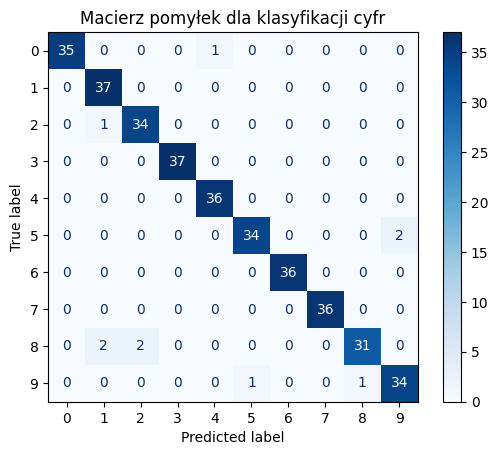

In [2]:
from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, digits.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, stratify=y)

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Skuteczność klasyfikacji na zbiorze cyfr: {accuracy:.4}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=digits.target_names)
disp.plot(cmap='Blues')
plt.title("Macierz pomyłek dla klasyfikacji cyfr")
plt.show()


## Zadanie 3

Proszę sprawdzić, jak zmieni się poprawność klasyfikacji na zbiorze ręcznie pisanych cyfr dla różnych architektur sieci, funkcji aktywacji, ilości epok uczenia i algorytmów uczenia. Proszę zbadać wpływ współczynnika uczenia (learning_rate) podczas używania algorytmu SGD. Dla najciekawszych przykładów proszę wypisać macierze pomyłek oraz wyliczyć wszystkie poznane metryki.

In [3]:
architectures = [(50,), (100,), (50, 50), (100, 50)]
activations = ["relu", "tanh", "logistic"]
max_iters = [200, 500, 1000]
solvers = ["adam", "sgd", "lbfgs"]
learning_rates = [0.001, 0.01, 0.1]

results = []

for arch in architectures:
    for activation in activations:
        for max_iter in max_iters:
            for solver in solvers:
                for lr in learning_rates:
                    classifier = MLPClassifier(
                        hidden_layer_sizes=arch,
                        activation=activation,
                        solver=solver,
                        learning_rate_init=lr,
                        max_iter=max_iter,
                    )

                    classifier.fit(X_train, y_train)
                    y_pred = classifier.predict(X_test)
                    acc = accuracy_score(y_test, y_pred)

                    results.append(
                        {
                            "arch": arch,
                            "activation": activation,
                            "max_iter": max_iter,
                            "solver": solver,
                            "learning_rate": lr if solver == "sgd" else None,
                            "accuracy": acc,
                            "classifier": classifier,
                        }
                    )


/home/zen1x/AGH/MIO/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/zen1x/AGH/MIO/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/zen1x/AGH/MIO/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/zen1x/AGH/MIO/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/zen1x/AGH/MIO/.ven

Najlepszy model
  Architektura: (50,)
  F. aktywacji: relu
  Maks. l. iteracji: 1000
  Algorytm uczenia: lbfgs
  Dokładność: 0.9806



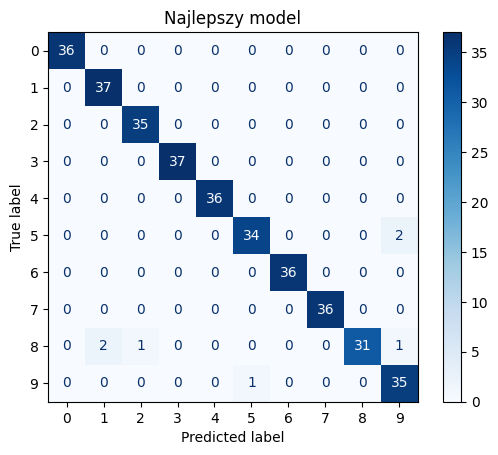

Metryki:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.95      1.00      0.97        37
           2       0.97      1.00      0.99        35
           3       1.00      1.00      1.00        37
           4       1.00      1.00      1.00        36
           5       0.97      0.94      0.96        36
           6       1.00      1.00      1.00        36
           7       1.00      1.00      1.00        36
           8       1.00      0.89      0.94        35
           9       0.92      0.97      0.95        36

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360

--------------------
Najlepszy model dla algorytmu adam
  Architektura: (100,)
  F. aktywacji: logistic
  Maks. l. iteracji: 1000
  Algorytm uczenia: adam
  Dokładność: 0.9806



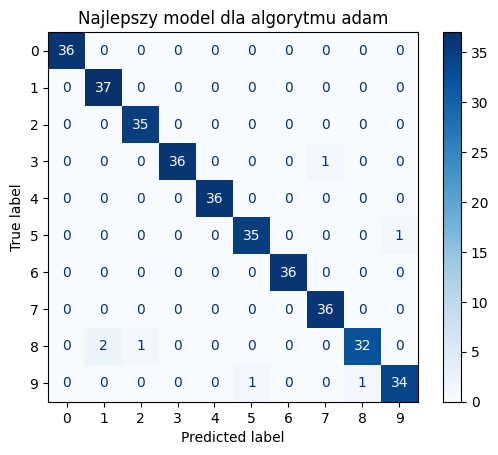

Metryki:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.95      1.00      0.97        37
           2       0.97      1.00      0.99        35
           3       1.00      0.97      0.99        37
           4       1.00      1.00      1.00        36
           5       0.97      0.97      0.97        36
           6       1.00      1.00      1.00        36
           7       0.97      1.00      0.99        36
           8       0.97      0.91      0.94        35
           9       0.97      0.94      0.96        36

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360

--------------------
Najlepszy model dla algorytmu sgd
  Architektura: (100,)
  F. aktywacji: relu
  Maks. l. iteracji: 500
  Algorytm uczenia: sgd
  Współczynnik uczenia: 0.1
  Dokładność: 0.9806



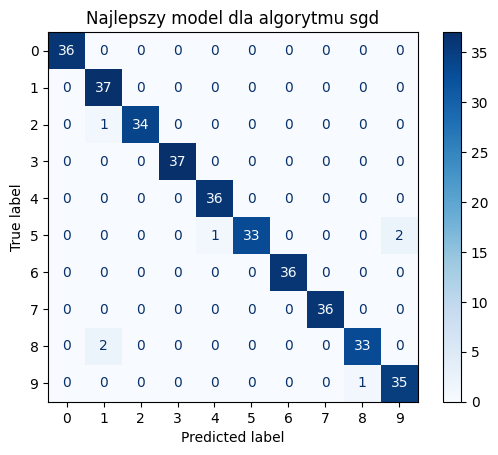

Metryki:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.93      1.00      0.96        37
           2       1.00      0.97      0.99        35
           3       1.00      1.00      1.00        37
           4       0.97      1.00      0.99        36
           5       1.00      0.92      0.96        36
           6       1.00      1.00      1.00        36
           7       1.00      1.00      1.00        36
           8       0.97      0.94      0.96        35
           9       0.95      0.97      0.96        36

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360

--------------------
Najlepszy model dla algorytmu lbfgs
  Architektura: (50,)
  F. aktywacji: relu
  Maks. l. iteracji: 1000
  Algorytm uczenia: lbfgs
  Dokładność: 0.9806



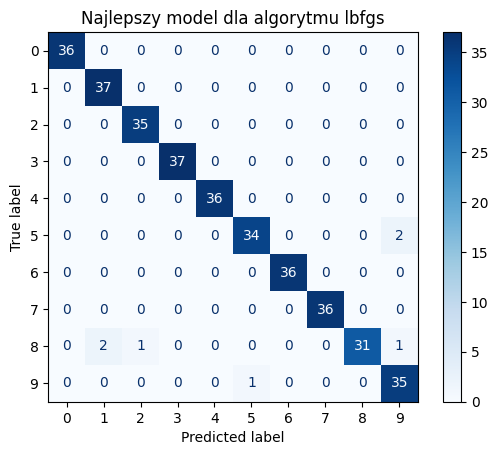

Metryki:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.95      1.00      0.97        37
           2       0.97      1.00      0.99        35
           3       1.00      1.00      1.00        37
           4       1.00      1.00      1.00        36
           5       0.97      0.94      0.96        36
           6       1.00      1.00      1.00        36
           7       1.00      1.00      1.00        36
           8       1.00      0.89      0.94        35
           9       0.92      0.97      0.95        36

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360

--------------------
Najlepszy model dla lr=0.001 (SGD)
  Architektura: (50,)
  F. aktywacji: tanh
  Maks. l. iteracji: 500
  Algorytm uczenia: sgd
  Współczynnik uczenia: 0.001
  Dokładność: 0.9750



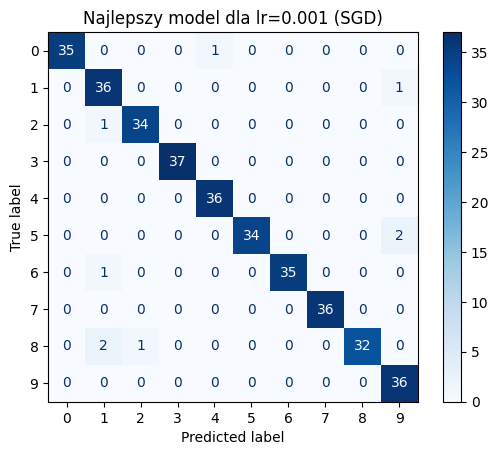

Metryki:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.90      0.97      0.94        37
           2       0.97      0.97      0.97        35
           3       1.00      1.00      1.00        37
           4       0.97      1.00      0.99        36
           5       1.00      0.94      0.97        36
           6       1.00      0.97      0.99        36
           7       1.00      1.00      1.00        36
           8       1.00      0.91      0.96        35
           9       0.92      1.00      0.96        36

    accuracy                           0.97       360
   macro avg       0.98      0.97      0.98       360
weighted avg       0.98      0.97      0.98       360

--------------------
Najlepszy model dla lr=0.01 (SGD)
  Architektura: (100, 50)
  F. aktywacji: relu
  Maks. l. iteracji: 200
  Algorytm uczenia: sgd
  Współczynnik uczenia: 0.01
  Dokładność: 0.9778



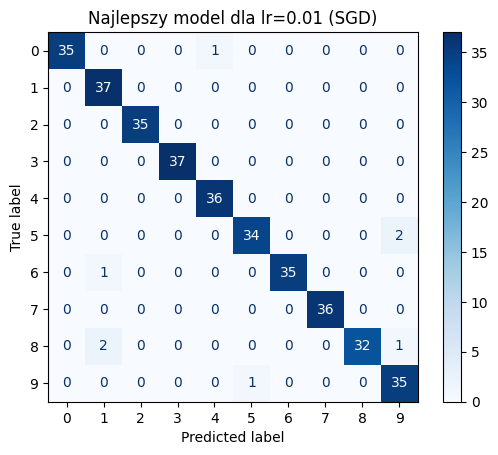

Metryki:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.93      1.00      0.96        37
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        37
           4       0.97      1.00      0.99        36
           5       0.97      0.94      0.96        36
           6       1.00      0.97      0.99        36
           7       1.00      1.00      1.00        36
           8       1.00      0.91      0.96        35
           9       0.92      0.97      0.95        36

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360

--------------------
Najlepszy model dla lr=0.1 (SGD)
  Architektura: (100,)
  F. aktywacji: relu
  Maks. l. iteracji: 500
  Algorytm uczenia: sgd
  Współczynnik uczenia: 0.1
  Dokładność: 0.9806



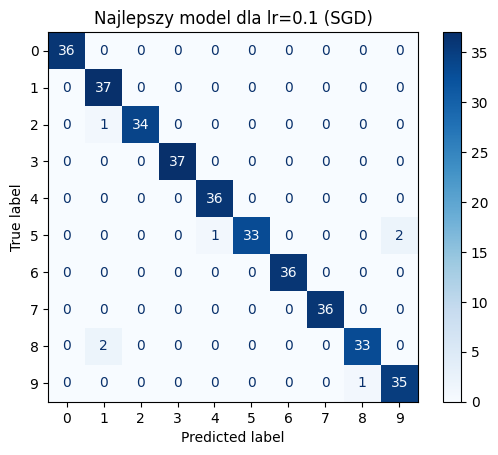

Metryki:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.93      1.00      0.96        37
           2       1.00      0.97      0.99        35
           3       1.00      1.00      1.00        37
           4       0.97      1.00      0.99        36
           5       1.00      0.92      0.96        36
           6       1.00      1.00      1.00        36
           7       1.00      1.00      1.00        36
           8       0.97      0.94      0.96        35
           9       0.95      0.97      0.96        36

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360

--------------------


In [4]:
from sklearn.metrics import classification_report

# sort by best overall
results_sorted = sorted(results, key=lambda res: res['accuracy'], reverse=True)

# best by each solver
best_by_solver = {}
for solver in solvers:
  # get results only for that specific solver
  solver_results = [res for res in results if res['solver'] == solver]
  solver_results_sorted = sorted(solver_results, key=lambda res:res['accuracy'], reverse=True)
  best_by_solver[solver] = solver_results_sorted[0]

# best by lr (SGD)
best_by_sgd_lr = {}
for lr in learning_rates:
    lr_results = [res for res in results if res['solver'] == 'sgd' and res['learning_rate'] == lr]
    lr_results_sorted = sorted(lr_results, key=lambda res: res['accuracy'], reverse=True)
    best_by_sgd_lr[lr] = lr_results_sorted[0]

def display_model_performance(title, classifier_info):
    print(title)
    print(f"  Architektura: {classifier_info['arch']}")
    print(f"  F. aktywacji: {classifier_info['activation']}")
    print(f"  Maks. l. iteracji: {classifier_info['max_iter']}")
    print(f"  Algorytm uczenia: {classifier_info['solver']}")
    if classifier_info['solver'] == 'sgd':
        print(f"  Współczynnik uczenia: {classifier_info['learning_rate']}")
    print(f"  Dokładność: {classifier_info['accuracy']:.4f}\n")
    
    # cm
    y_pred = classifier_info['classifier'].predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=digits.target_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()
    
    # metrics
    print("Metryki:")
    print(classification_report(y_test, y_pred, target_names=[str(x) for x in digits.target_names]))
    print("-"*20)

# best overall
display_model_performance("Najlepszy model", results_sorted[0])

for solver, info in best_by_solver.items():
    display_model_performance(f"Najlepszy model dla algorytmu {solver}", info)

for lr, info in best_by_sgd_lr.items():
    display_model_performance(f"Najlepszy model dla lr={lr} (SGD)", info)

## Zadanie 4

Proszę pobrać zbiór yeast z UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Yeast). Proszę we własnym zakresie dokonać wstępnej analizy i przygotowania tego zbioru. Warto zauważyć, że liczności różnych klas wewnątrz zbioru są _bardzo_ nierówne. Proszę spróbować osiągnąć jak najlepsze wyniki i narysować dla nich macierz pomyłek (dla zbioru uczącego i testującego) oraz wyliczyć wszystkie poznane do tej pory metryki. Czy dokładność na poziomie 0.5 dla takiego zbioru jest dobra? Mogą państwo zbadać też czas wykonywania funkcji fit dla różnych konfiguracji sieci.

In [25]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
)
from ucimlrepo import fetch_ucirepo

# load the dataset via uci repo

yeast = fetch_ucirepo(id=110)
X = yeast.data.features
y = yeast.data.targets.values.ravel()

yeast.data.original.head()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# stratify cuz some classes are very sparse
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, train_size=0.8, stratify=y
)

# different models / classifiers to test
configs = [
    {"hidden_layer_sizes": (50,), "solver": "adam"},
    {"hidden_layer_sizes": (100,), "solver": "adam"},
    {"hidden_layer_sizes": (50, 50), "solver": "adam"},
    {"hidden_layer_sizes": (100, 50), "solver": "adam"},
    {
        "hidden_layer_sizes": (50,),
        "solver": "sgd",
        "learning_rate_init": 0.01,
    },
    {
        "hidden_layer_sizes": (50,),
        "solver": "sgd",
        "learning_rate_init": 0.1,
    },
    {"hidden_layer_sizes": (50,), "solver": "lbfgs"},
]

max_iters = [500, 1000, 2000]

results = []
for config in configs:
    for max_iter in max_iters:
        classifier = MLPClassifier(**config, max_iter=max_iter)

        start_time = time.time()
        classifier.fit(X_train, y_train)
        fit_time = time.time() - start_time

        acc_train = accuracy_score(y_train, classifier.predict(X_train))
        acc_test = accuracy_score(y_test, classifier.predict(X_test))

        f1_macro = f1_score(y_test, classifier.predict(X_test), average="macro")
        f1_weighted = f1_score(y_test, classifier.predict(X_test), average="weighted")

        results.append(
            {
                "arch": config["hidden_layer_sizes"],
                "solver": config["solver"],
                "max_iter": max_iter,
                "lr": config["learning_rate_init"]
                if config["solver"] == "sgd"
                else None,
                "acc_train": acc_train,
                "acc_test": acc_test,
                "f1_macro": f1_macro,
                "f1_weighted": f1_weighted,
                "fit_time": fit_time,
                "classifier": classifier,
            }
        )

        print(f"Config: {config}, max iter: {max_iter}")
        print(f"  Test accuracy: {acc_test:.4}")
        print(f"  F1 macro: {f1_macro:.4}")
        print(f"  F1 weighted: {f1_weighted:.4}")
        print(f"  Fit time: {fit_time:.4} sec(s)")
        print("-" * 50)

/home/zen1x/AGH/MIO/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: {'hidden_layer_sizes': (50,), 'solver': 'adam'}, max iter: 500
  Test accuracy: 0.596
  F1 macro: 0.5368
  F1 weighted: 0.5877
  Fit time: 0.7003 sec(s)
--------------------------------------------------


/home/zen1x/AGH/MIO/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: {'hidden_layer_sizes': (50,), 'solver': 'adam'}, max iter: 1000
  Test accuracy: 0.5488
  F1 macro: 0.4817
  F1 weighted: 0.5421
  Fit time: 1.469 sec(s)
--------------------------------------------------
Config: {'hidden_layer_sizes': (50,), 'solver': 'adam'}, max iter: 2000
  Test accuracy: 0.5724
  F1 macro: 0.5323
  F1 weighted: 0.5681
  Fit time: 2.68 sec(s)
--------------------------------------------------


/home/zen1x/AGH/MIO/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: {'hidden_layer_sizes': (100,), 'solver': 'adam'}, max iter: 500
  Test accuracy: 0.5791
  F1 macro: 0.5156
  F1 weighted: 0.5732
  Fit time: 0.9148 sec(s)
--------------------------------------------------


/home/zen1x/AGH/MIO/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: {'hidden_layer_sizes': (100,), 'solver': 'adam'}, max iter: 1000
  Test accuracy: 0.5758
  F1 macro: 0.4679
  F1 weighted: 0.5677
  Fit time: 1.906 sec(s)
--------------------------------------------------


/home/zen1x/AGH/MIO/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: {'hidden_layer_sizes': (100,), 'solver': 'adam'}, max iter: 2000
  Test accuracy: 0.5286
  F1 macro: 0.4682
  F1 weighted: 0.5211
  Fit time: 3.84 sec(s)
--------------------------------------------------


/home/zen1x/AGH/MIO/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: {'hidden_layer_sizes': (50, 50), 'solver': 'adam'}, max iter: 500
  Test accuracy: 0.5286
  F1 macro: 0.4093
  F1 weighted: 0.5215
  Fit time: 1.149 sec(s)
--------------------------------------------------


/home/zen1x/AGH/MIO/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: {'hidden_layer_sizes': (50, 50), 'solver': 'adam'}, max iter: 1000
  Test accuracy: 0.5118
  F1 macro: 0.5051
  F1 weighted: 0.5072
  Fit time: 2.443 sec(s)
--------------------------------------------------
Config: {'hidden_layer_sizes': (50, 50), 'solver': 'adam'}, max iter: 2000
  Test accuracy: 0.5387
  F1 macro: 0.5137
  F1 weighted: 0.5326
  Fit time: 2.216 sec(s)
--------------------------------------------------


/home/zen1x/AGH/MIO/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: {'hidden_layer_sizes': (100, 50), 'solver': 'adam'}, max iter: 500
  Test accuracy: 0.5589
  F1 macro: 0.524
  F1 weighted: 0.5505
  Fit time: 1.661 sec(s)
--------------------------------------------------
Config: {'hidden_layer_sizes': (100, 50), 'solver': 'adam'}, max iter: 1000
  Test accuracy: 0.5051
  F1 macro: 0.469
  F1 weighted: 0.4984
  Fit time: 2.896 sec(s)
--------------------------------------------------
Config: {'hidden_layer_sizes': (100, 50), 'solver': 'adam'}, max iter: 2000
  Test accuracy: 0.5118
  F1 macro: 0.4263
  F1 weighted: 0.5019
  Fit time: 4.232 sec(s)
--------------------------------------------------


/home/zen1x/AGH/MIO/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: {'hidden_layer_sizes': (50,), 'solver': 'sgd', 'learning_rate_init': 0.01}, max iter: 500
  Test accuracy: 0.5758
  F1 macro: 0.5244
  F1 weighted: 0.5671
  Fit time: 0.6568 sec(s)
--------------------------------------------------


/home/zen1x/AGH/MIO/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: {'hidden_layer_sizes': (50,), 'solver': 'sgd', 'learning_rate_init': 0.01}, max iter: 1000
  Test accuracy: 0.5758
  F1 macro: 0.5587
  F1 weighted: 0.5674
  Fit time: 1.329 sec(s)
--------------------------------------------------
Config: {'hidden_layer_sizes': (50,), 'solver': 'sgd', 'learning_rate_init': 0.01}, max iter: 2000
  Test accuracy: 0.5387
  F1 macro: 0.4632
  F1 weighted: 0.5311
  Fit time: 2.062 sec(s)
--------------------------------------------------
Config: {'hidden_layer_sizes': (50,), 'solver': 'sgd', 'learning_rate_init': 0.1}, max iter: 500
  Test accuracy: 0.5286
  F1 macro: 0.4964
  F1 weighted: 0.5192
  Fit time: 0.3113 sec(s)
--------------------------------------------------
Config: {'hidden_layer_sizes': (50,), 'solver': 'sgd', 'learning_rate_init': 0.1}, max iter: 1000
  Test accuracy: 0.5421
  F1 macro: 0.4568
  F1 weighted: 0.5266
  Fit time: 0.2515 sec(s)
--------------------------------------------------
Config: {'hidden_layer_sizes': (50,), 'so

/home/zen1x/AGH/MIO/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Config: {'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}, max iter: 500
  Test accuracy: 0.5051
  F1 macro: 0.5288
  F1 weighted: 0.5025
  Fit time: 0.6613 sec(s)
--------------------------------------------------


/home/zen1x/AGH/MIO/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Config: {'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}, max iter: 1000
  Test accuracy: 0.4444
  F1 macro: 0.3908
  F1 weighted: 0.4448
  Fit time: 1.216 sec(s)
--------------------------------------------------
Config: {'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}, max iter: 2000
  Test accuracy: 0.5051
  F1 macro: 0.3544
  F1 weighted: 0.5064
  Fit time: 2.682 sec(s)
--------------------------------------------------


/home/zen1x/AGH/MIO/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [26]:
df_results = pd.DataFrame(results)

df_sorted_acc = df_results.sort_values(by="acc_test", ascending=False)
df_sorted_f1 = df_results.sort_values(by="f1_macro", ascending=False)

print("-- Sorted by test acc")
print(
    df_sorted_acc[
        [
            "arch",
            "solver",
            "lr",
            "acc_train",
            "acc_test",
            "f1_macro",
            "f1_weighted",
            "fit_time",
        ]
    ].round(4)
)

print("\n-- Sorted by macro F1")
print(
    df_sorted_f1[
        [
            "arch",
            "solver",
            "lr",
            "acc_train",
            "acc_test",
            "f1_macro",
            "f1_weighted",
            "fit_time",
        ]
    ].round(4)
)

-- Sorted by test acc
         arch solver    lr  acc_train  acc_test  f1_macro  f1_weighted  \
0       (50,)   adam   NaN     0.6824    0.5960    0.5368       0.5877   
3      (100,)   adam   NaN     0.6866    0.5791    0.5156       0.5732   
4      (100,)   adam   NaN     0.7473    0.5758    0.4679       0.5677   
13      (50,)    sgd  0.01     0.7035    0.5758    0.5587       0.5674   
12      (50,)    sgd  0.01     0.6782    0.5758    0.5244       0.5671   
2       (50,)   adam   NaN     0.7287    0.5724    0.5323       0.5681   
9   (100, 50)   adam   NaN     0.8382    0.5589    0.5240       0.5505   
1       (50,)   adam   NaN     0.6942    0.5488    0.4817       0.5421   
16      (50,)    sgd  0.10     0.7085    0.5421    0.4568       0.5266   
17      (50,)    sgd  0.10     0.7161    0.5387    0.4968       0.5341   
14      (50,)    sgd  0.01     0.7220    0.5387    0.4632       0.5311   
8    (50, 50)   adam   NaN     0.8888    0.5387    0.5137       0.5326   
5      (100,)   

Best config by macro F1:
  Arch: (50,)
  Solver: sgd
  Learning rate: 0.01
  Accuracy (test): 0.5758
  Macro F1 (test): 0.5587
  Weighted F1 (test): 0.5674
  Training time: 1.329 sec


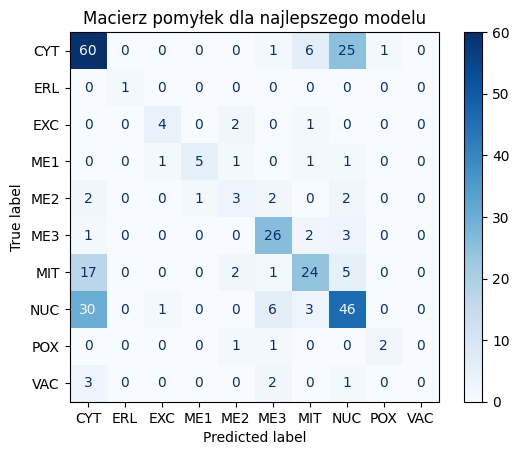

Metryki dla najlepszego modelu
              precision    recall  f1-score   support

         CYT       0.53      0.65      0.58        93
         ERL       1.00      1.00      1.00         1
         EXC       0.67      0.57      0.62         7
         ME1       0.83      0.56      0.67         9
         ME2       0.33      0.30      0.32        10
         ME3       0.67      0.81      0.73        32
         MIT       0.65      0.49      0.56        49
         NUC       0.55      0.53      0.54        86
         POX       0.67      0.50      0.57         4
         VAC       0.00      0.00      0.00         6

    accuracy                           0.58       297
   macro avg       0.59      0.54      0.56       297
weighted avg       0.57      0.58      0.57       297



/home/zen1x/AGH/MIO/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/zen1x/AGH/MIO/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/zen1x/AGH/MIO/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
best_f1_row = df_sorted_f1.iloc[0]
best_clf = best_f1_row["classifier"]

print("Best config by macro F1:")
print(f"  Arch: {best_f1_row['arch']}")
print(f"  Solver: {best_f1_row['solver']}")
print(f"  Learning rate: {best_f1_row['lr']}")
print(f"  Accuracy (test): {best_f1_row['acc_test']:.4}")
print(f"  Macro F1 (test): {best_f1_row['f1_macro']:.4}")
print(f"  Weighted F1 (test): {best_f1_row['f1_weighted']:.4}")
print(f"  Training time: {best_f1_row['fit_time']:.4} sec")

y_pred_best = best_clf.predict(X_test)

# cm
labels = np.sort(np.unique(y))
cm = confusion_matrix(y_test, y_pred_best, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Macierz pomyłek dla najlepszego modelu")
plt.show()

print("Metryki dla najlepszego modelu")
print(classification_report(y_test, y_pred_best))

In [44]:
most_common_class = pd.Series(y_train).value_counts().idxmax()
baseline_acc = np.mean(y_test == most_common_class)
print(f"Przewidując zawsze najczęściej występującą klasę, otrzymalibyśmy dokładność = {baseline_acc:.4f}")

Przewidując zawsze najczęściej występującą klasę, otrzymalibyśmy dokładność = 0.3131
